# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть EfficientNetB6 и дообучить под нашу задачу. 

Также в ноутбуке будут использоваться такие приемы, как:
* аугментация при помощи библиотеке albumentations
* политика One Cycle Policy для Learning Rate
* аугментация изображений из тестовой выборки - test time augmentation (TTA)

# Установка и импорт необходимых библиотек

In [2]:
!nvidia-smi

Mon Oct 12 23:52:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3080    Off  | 00000000:0B:00.0  On |                  N/A |
|  0%   32C    P8    18W / 320W |    326MiB / 10014MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
import zipfile

from cycliclr import CyclicLR

from ImageDataAugmentor.image_data_augmentor import *
import albumentations

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(os.getcwd() + "/input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

INFO:tensorflow:Using local port 17602
INFO:tensorflow:Using local port 22816
INFO:tensorflow:Using local port 18735
INFO:tensorflow:Using local port 16988
INFO:tensorflow:Using local port 17240
INFO:tensorflow:Using local port 23295
INFO:tensorflow:Using local port 19134
INFO:tensorflow:Using local port 22225
INFO:tensorflow:Using local port 23599
INFO:tensorflow:Using local port 24825
['model_last.hdf5', 'train.csv', 'sample-submission.csv', 'test_upload', 'train']
Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.18.5
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# Основные настройки

In [5]:
# Batch size
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
BATCH_SIZE_STEP4     = 2

# Epochs
EPOCHS_STEP1         = 10  # эпох на обучение
EPOCHS_STEP2         = 10  # эпох на обучение  
EPOCHS_STEP3         = 10  # эпох на обучение  
EPOCHS_STEP4         = 7  # эпох на обучение  

# Learning Rates
LR_STEP1             = 1e-3
LR_STEP2             = 1e-4
LR_STEP3             = 1e-5
LR_STEP4             = 1e-5

# Learning Rate One Cycle Policy
MAX_MOMENTUM = 0.98
BASE_MOMENTUM = 0.85
CYCLICAL_MOMENTUM = True
AUGMENT = True
CYCLES = 2.35

# Test-validation split
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_SIZE_STEP4       = 512

IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = os.getcwd() + '/input/'
PATH = os.getcwd() + '/input/' # рабочая директория

# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [6]:
# Implement One Cycle Policy Algorithm in the Keras Callback Class

from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *

class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            
            
    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())

# EDA / Анализ данных

In [7]:
df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [9]:
df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Пример картинок (random sample)


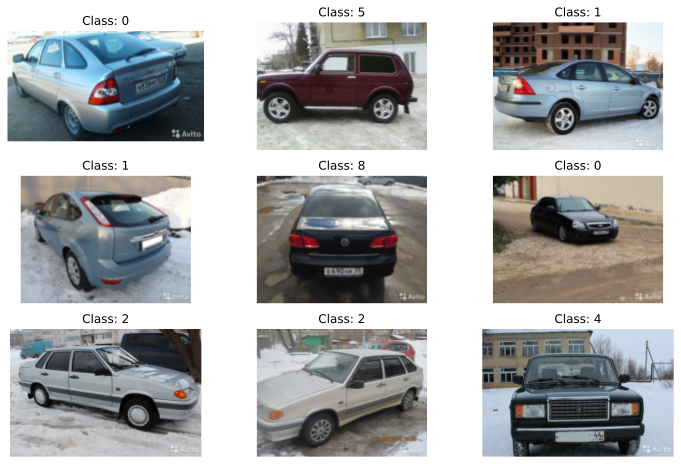

In [10]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

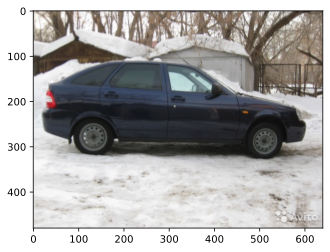

(640, 480)

In [11]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Видим, что классы указывают на модели автомобилей ВАЗ

# Подготовка данных

### Аугментация данных

Аугментация с использованием библиотеки Albumentations

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=250, width=200),
        albumentations.CenterCrop(height=200, width=250),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

### Генерация данных

In [13]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Пример картинок из train_generator


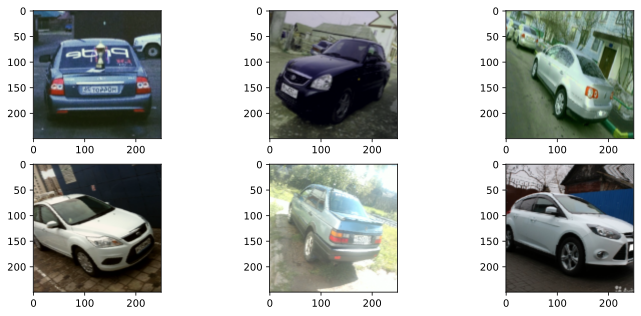

In [14]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


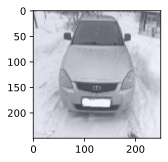

In [15]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,1):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

На момент выполнения задания сеть EfficientNetB6 все ещё является оптимальным выбором, если брать во внимание точность предсказаний и время работы.

### Загружаем предобученную сеть EfficientNetB6:

In [16]:
base_model = efn.EfficientNetB6(
    weights='imagenet', # Подгружаем веса imagenet
    include_top=False,  # Выходной слой (голову) будем менять т.к. у нас другиe классы
    input_shape=input_shape)

In [17]:
# Посмотрим на загруженную модель EfficientNetB6
base_model.summary()

________________
block6h_project_bn (BatchNormal (None, 8, 8, 344)    1376        block6h_project_conv[0][0]       
__________________________________________________________________________________________________
block6h_drop (FixedDropout)     (None, 8, 8, 344)    0           block6h_project_bn[0][0]         
__________________________________________________________________________________________________
block6h_add (Add)               (None, 8, 8, 344)    0           block6h_drop[0][0]               
                                                                 block6g_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_conv (Conv2D)    (None, 8, 8, 2064)   710016      block6h_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_bn (BatchNormali (None, 8, 8, 2064)   8256        block6i_expand_conv[0][0]  

In [18]:
# Для начала заморозим веса EfficientNetB6 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

Устанавливаем "голову"

In [19]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))

model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [20]:
# Смотрим на получившуюся модель
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [21]:
# Количество слоев
print(len(model.layers))

6


In [22]:
# Количество параметров обучения
len(model.trainable_variables)

6

In [23]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f30400c49d0> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3040087160> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2fa4170af0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2f74710fa0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2f74725730> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2f74725ee0> True


# Обучение модели

## Step 1 - обучение "головы"

In [23]:
# Настройки
batch_size = BATCH_SIZE
epochs = EPOCHS_STEP1
base_lr = LR_STEP1
max_lr = base_lr*10
max_m = MAX_MOMENTUM
base_m = BASE_MOMENTUM

cyclical_momentum = CYCLICAL_MOMENTUM
augment = AUGMENT
cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
    )

Epoch 1/10
1556/1556 [==============================] - 99s 58ms/step - loss: 1.9705 - accuracy: 0.3493 - val_loss: 1.1076 - val_accuracy: 0.6024

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 89s 57ms/step - loss: 1.5060 - accuracy: 0.4694 - val_loss: 1.0400 - val_accuracy: 0.6318

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 88s 57ms/step - loss: 1.3802 - accuracy: 0.5235 - val_loss: 0.9571 - val_accuracy: 0.6678

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 89s 57ms/step - loss: 1.2838 - accuracy: 0.5496 - val_loss: 0.8759 - val_accuracy: 0.6927

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1556/1556 [==============================] - 88s 57ms/step - loss: 1.2858 - accuracy: 0.5475 - val_loss: 0.9126 - val_accuracy: 0.6817

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1556/1556 [==================

Смотрим, как изменялись learning rate и momentum в процессе обучения

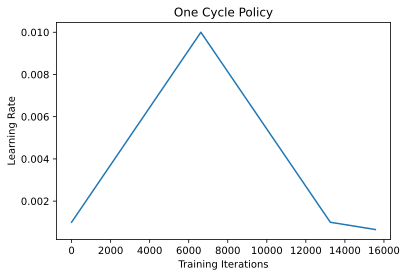

In [24]:
# Plot Learning Rate
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['lr'])
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("One Cycle Policy")
plt.show()

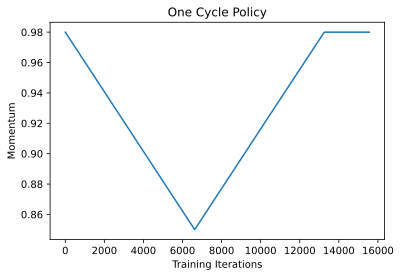

In [25]:
# Plot momentum
import matplotlib.pyplot as plt
plt.plot(clr.history['iterations'], clr.history['momentum'])
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("One Cycle Policy")
plt.show()

In [26]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 18s 46ms/step - loss: 0.7603 - accuracy: 0.7243
Accuracy: 72.43%


In [27]:
# Сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

## Step 2 - FineTuning - обучение половины весов EfficientNetb6

In [28]:
# Посмотрим на количество слоев в базовой модели
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [29]:
# Разморозим базовую модель
base_model.trainable = True

# Установим количество слоев, которые будем переобучать
fine_tune_at = len(base_model.layers)//2

# Заморозим первую половину слоев
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [30]:
# Количество параметров
len(base_model.trainable_variables)

291

In [31]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f1c75858f70> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1bcc3eb850> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1c757e4820> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1b600cafa0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1b600e0730> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1b600e0ee0> True


Вновь обучаем модель, используя One Cycle Policy для Learning Rate

In [32]:
# Настройки
#batch_size = BATCH_SIZE
epochs = EPOCHS_STEP2
base_lr = LR_STEP2
max_lr = base_lr*10
#max_m = MAX_MOMENTUM
#base_m = BASE_MOMENTUM

#cyclical_momentum = CYCLICAL_MOMENTUM
#augment = AUGMENT
#cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
#checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
#earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - 133s 80ms/step - loss: 1.6107 - accuracy: 0.4811 - val_loss: 0.5708 - val_accuracy: 0.7922

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 122s 79ms/step - loss: 0.8314 - accuracy: 0.7051 - val_loss: 0.4156 - val_accuracy: 0.8505

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 113s 73ms/step - loss: 0.6581 - accuracy: 0.7735 - val_loss: 0.3430 - val_accuracy: 0.8798

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 114s 73ms/step - loss: 0.5285 - accuracy: 0.8146 - val_loss: 0.2731 - val_accuracy: 0.9034

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1556/1556 [==============================] - 120s 77ms/step - loss: 0.4697 - accuracy: 0.8349 - val_loss: 0.2532 - val_accuracy: 0.9098

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1556/1556 [=============

In [33]:
# Сохраним модель
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [34]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 18s 46ms/step - loss: 0.1922 - accuracy: 0.9341
Accuracy: 93.41%


In [35]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 18s 45ms/step - loss: 0.1964 - accuracy: 0.9321
Accuracy: 93.21%


#Загрузка сохранненой модели после перезапуска ядра Jupyter  

#Для продолжения сразу со Step 3

In [36]:
#model = keras.models.load_model('../working/model_step2.hdf5')
#model.load_weights('best_model.hdf5')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
____________________________________

## Step 3 - FineTuning - разморозка всей сети EfficientNetB6 и дообучение

Разморозим базовую модель

In [38]:
base_model.trainable = True

Повторно обучим модель, предварительно разморозив все слои

In [39]:
# Настройки
batch_size = BATCH_SIZE
epochs = EPOCHS_STEP3
base_lr = LR_STEP3
max_lr = base_lr*10
max_m = MAX_MOMENTUM
base_m = BASE_MOMENTUM

cyclical_momentum = CYCLICAL_MOMENTUM
augment = AUGMENT
cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - 252s 156ms/step - loss: 0.3020 - accuracy: 0.8980 - val_loss: 0.1765 - val_accuracy: 0.9356

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 226s 145ms/step - loss: 0.2843 - accuracy: 0.9011 - val_loss: 0.1785 - val_accuracy: 0.9340

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 217s 140ms/step - loss: 0.2910 - accuracy: 0.8989 - val_loss: 0.1763 - val_accuracy: 0.9375

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 218s 140ms/step - loss: 0.2618 - accuracy: 0.9105 - val_loss: 0.1775 - val_accuracy: 0.9414

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1556/1556 [==============================] - 217s 140ms/step - loss: 0.2666 - accuracy: 0.9085 - val_loss: 0.1648 - val_accuracy: 0.9446

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1556/1556 [========

In [40]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [41]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 17s 44ms/step - loss: 0.1619 - accuracy: 0.9463
Accuracy: 94.63%


In [42]:
base_model.input_shape

(None, 250, 250, 3)

In [43]:
model.input_shape

(None, 250, 250, 3)

In [24]:
model = keras.models.load_model('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

## Step - увеличение размера изображения

Увеличим размер изображения и уменьшим уровень аугментации

In [26]:
IMG_SIZE             = IMG_SIZE_STEP4
BATCH_SIZE           = BATCH_SIZE_STEP4
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [27]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    # albumentations.OneOf([
    #     albumentations.CenterCrop(height=250, width=200),
    #     albumentations.CenterCrop(height=200, width=250),
    # ],p=0.5),
    # albumentations.OneOf([
    #     albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
    #     albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    # ],p=0.5),
    # albumentations.GaussianBlur(p=0.05),
    # albumentations.HueSaturationValue(p=0.5),
    # albumentations.RGBShift(p=0.5),
    # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    # albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [28]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Заново создаем сеть с новым размером входных данных

In [58]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [29]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=0.00001), metrics=["accuracy"])

In [63]:
model.load_weights('best_model.hdf5')

In [30]:
# Настройки
batch_size = BATCH_SIZE_STEP4
epochs = EPOCHS_STEP4
base_lr = LR_STEP4
max_lr = base_lr*10
max_m = MAX_MOMENTUM
base_m = BASE_MOMENTUM

cyclical_momentum = CYCLICAL_MOMENTUM
augment = AUGMENT
cycles = CYCLES

# Расчет количества итерация и шага изменения learning rate
iterations = round(train_generator.samples//train_generator.batch_size*epochs)
iterations = list(range(0,iterations+1))
step_size = len(iterations)/(cycles)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=base_lr, momentum=BASE_MOMENTUM), metrics=["accuracy"])

model.load_weights('best_model.hdf5') # Подгружаем ранее обученные веса

clr =  CyclicLR(
    base_lr=base_lr,
    max_lr=max_lr,
    step_size=step_size,
    max_m=max_m,
    base_m=base_m,
    cyclical_momentum=cyclical_momentum
)
    
# Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.    
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop, clr]

# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_data = test_generator, 
    validation_steps = test_generator.samples//test_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks_list
)

Epoch 1/7
6226/6226 [==============================] - 931s 148ms/step - loss: 1.0618 - accuracy: 0.7044 - val_loss: 0.1763 - val_accuracy: 0.9556

Epoch 00001: saving model to best_model.hdf5
Epoch 2/7
6226/6226 [==============================] - 904s 145ms/step - loss: 0.8088 - accuracy: 0.7886 - val_loss: 0.1520 - val_accuracy: 0.9627

Epoch 00002: saving model to best_model.hdf5
Epoch 3/7
6226/6226 [==============================] - 904s 145ms/step - loss: 0.7624 - accuracy: 0.8060 - val_loss: 0.1492 - val_accuracy: 0.9636

Epoch 00003: saving model to best_model.hdf5
Epoch 4/7
6226/6226 [==============================] - 904s 145ms/step - loss: 0.6796 - accuracy: 0.8292 - val_loss: 0.1628 - val_accuracy: 0.9636

Epoch 00004: saving model to best_model.hdf5
Epoch 5/7
6226/6226 [==============================] - 918s 147ms/step - loss: 0.6486 - accuracy: 0.8339 - val_loss: 0.1573 - val_accuracy: 0.9662

Epoch 00005: saving model to best_model.hdf5
Epoch 6/7
6226/6226 [==============

In [31]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [32]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1555/1555 [==============================] - 59s 38ms/step - loss: 0.1604 - accuracy: 0.9688
Accuracy: 96.88%


# Предсказание на тестовых данных

In [33]:
from sklearn.metrics import accuracy_score

In [34]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [35]:
test_sub_generator.samples

6675

In [36]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

3338/3338 [==============================] - 123s 37ms/step


In [37]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [38]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


## Test Time Augmentation
https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде.
Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [29]:
model.load_weights('best_model.hdf5')

In [30]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=250, width=200),
        albumentations.CenterCrop(height=200, width=250),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [56]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [31]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

3338/3338 [==============================] - 119s 36ms/step


In [32]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [33]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


# Итоги

В ходе выполнения проекта были применены следующие методы:
* transfer learning и fine-tuning
* настройка LR, optimizer, loss
* подобраны переменные (размер картинки, батч и т.д.)
* SOTA архитектура сетей - EfficientNetB6
* добавлена Batch Normalization и изменена архитектура “головы”
* применены дополнительные функции callback Keras https://keras.io/callbacks/ 
* TTA (Test Time Augmentation)
* Дополнительно*: разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: использована более продвинутая библиотеки аугментации изображений (Albumentations )

In [6]:
model = keras.models.load_model('../working/model_step3.hdf5')


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 41,328,866
Non-trainable params: 224,944
______________________________________

In [12]:
model = new_model